## **Implementation of Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving **nonlinear** partial differential equations.**

- Developed by. Ronald Borja-Roman
- PhD. Student in Chemical Engineering at Rowan University, 2025

**Momentum Equation (Stokes' first problem):**

\begin{aligned}
\frac{\partial v_x}{\partial t} = \nu \frac{\partial^2 v_x}{\partial y^2}
\end{aligned}

**Initial and Boundary Conditions:**

\begin{aligned}
v_x(y,0) &= 0, \\
v_x(0,t) &= V, \\
v_x(inf,t) &= 0.
\end{aligned}




1. Analytical Solution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.special import erf

nu = 1e-4
U0 = 1.0
T = 2.0
y_max = 5 * np.sqrt(nu * T)
y = np.linspace(0, y_max, 200)

def plot_profile(t):
    v_analytical = U0 * (1 - erf(y / (2 * np.sqrt(nu * t))))
    plt.figure(figsize=(6,4))
    plt.plot(y, v_analytical)
    plt.title(f'Analytical Solution at t = {t:.2f} s')
    plt.xlabel('y [m]')
    plt.ylabel('v [m/s]')
    plt.grid(True)
    plt.show()

interact(plot_profile, t=(0.01, T, 0.01));

interactive(children=(FloatSlider(value=1.0, description='t', max=2.0, min=0.01, step=0.01), Output()), _dom_c…

2. Physics Informed Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd

# 1. ARCHITECTURE
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t, y):
      inputs = torch.cat((t, y), dim=1)
      return self.net(inputs)

In [ ]:
# 2. TRAINING DATA
# PDE
N_f = 10000
y_f = np.random.uniform(0, y_max, (N_f, 1))
t_f = np.random.uniform(0, T, (N_f, 1))
X_f = np.hstack([y_f, t_f])
X_f = torch.tensor(X_f, dtype=torch.float32, requires_grad=True)

# I.C -> at t=0 and any position y, v = 0 m/s
N0 = 200
y0 = np.linspace(0, y_max, N0).reshape(-1, 1)
t0 = np.zeros_like(y0)
v0 = np.zeros_like(y0)

X0 = torch.tensor(np.hstack([y0, t0]), dtype=torch.float32)
V0 = torch.tensor(v0, dtype=torch.float32)

# B.C1 -> at y = 0, vx = V
N_b = 200
t_b = np.random.uniform(0, T, (N_b, 1))
y_b = np.zeros_like(t_b)
v_b0 = U0 * np.ones_like(t_b)

X_b0 = torch.tensor(np.hstack([y_b, t_b]), dtype=torch.float32)
V_b0 = torch.tensor(v_b0, dtype=torch.float32)

# at y = ymax, vx = 0
y_b1 = y_max * np.ones_like(t_b)
v_b1 = np.zeros_like(t_b)

Xb_1 = torch.tensor(np.hstack([y_b1, t_b]), dtype=torch.float32)
Vb_1 = torch.tensor(v_b1, dtype=torch.float32)

In [ ]:
# 3. LOSS FUNCTION
def pde_loss(model, y, t):
  v = model(y, t)
  v_t = autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
  v_y = autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
  v_yy = autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
  f = v_t - nu * v_yy
  return torch.mean(f**2)

def loss(model):

  # pde
  yf_grad = X_f[:, 0:1].clone().detach()
  tf_grad = X_f[:, 1:2].clone().detach()

  yf_grad.requires_grad = True
  tf_grad.requires_grad = True

  loss_f = pde_loss(model, yf_grad, tf_grad)

  # ic
  y0_t = X0[:, 0:1]
  t0_t = X0[:, 1:2]
  v0_pred = model(y0_t, t0_t)

  loss_ic = torch.mean((v0_pred - V0)**2)

  # bc
  yb0_t = X_b0[:, 0:1]
  tb0_t = X_b0[:, 1:2]
  vb0_pred = model(yb0_t, tb0_t)

  yb1_t = Xb_1[:, 0:1]
  tb1_t = Xb_1[:, 1:2]
  vb1_pred = model(yb1_t, tb1_t)

  loss_bc = torch.mean((vb0_pred - V_b0)**2) + torch.mean((vb1_pred - Vb_1)**2)

  return loss_f + loss_ic + loss_bc

In [ ]:
# TRAINING
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10000

for i in range(epochs):
  optimizer.zero_grad()
  L = loss(model)
  L.backward()
  optimizer.step()

  if i % 500 == 0:
    print(f'Epoch {i}, Loss: {L.item()}')

Epoch 0, Loss: 0.7862539887428284
Epoch 500, Loss: 0.15249118208885193
Epoch 1000, Loss: 0.1417204886674881
Epoch 1500, Loss: 0.0856463760137558
Epoch 2000, Loss: 0.0466587208211422
Epoch 2500, Loss: 0.04338257014751434
Epoch 3000, Loss: 0.03615332022309303
Epoch 3500, Loss: 0.026978936046361923
Epoch 4000, Loss: 0.023076504468917847
Epoch 4500, Loss: 0.021209105849266052
Epoch 5000, Loss: 0.019419165328145027
Epoch 5500, Loss: 0.01743246801197529
Epoch 6000, Loss: 0.01515454612672329
Epoch 6500, Loss: 0.01300645712763071
Epoch 7000, Loss: 0.01273514423519373
Epoch 7500, Loss: 0.011923015117645264
Epoch 8000, Loss: 0.010612718760967255
Epoch 8500, Loss: 0.010175533592700958
Epoch 9000, Loss: 0.009799710474908352
Epoch 9500, Loss: 0.009425926022231579


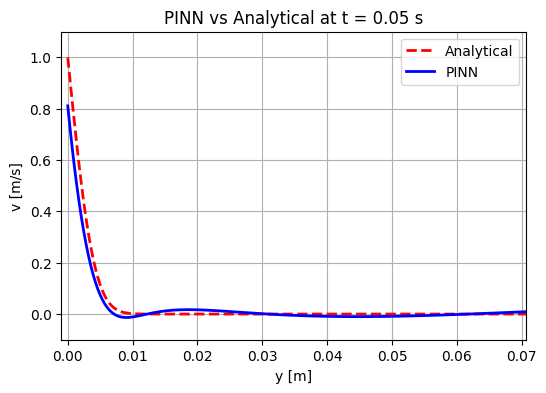

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.special import erf

nu = 1e-4
U0 = 1.0
T = 2.0
y_max = 5 * np.sqrt(nu * T)

y = np.linspace(0, y_max, 200).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(6,4))
line_analytical, = ax.plot([], [], 'r--', lw=2, label='Analytical')
line_pinn, = ax.plot([], [], 'b-', lw=2, label='PINN')
ax.set_xlim(-0.001, y_max)
ax.set_ylim(-0.1, U0 * 1.1)
ax.set_xlabel('y [m]')
ax.set_ylabel('v [m/s]')
ax.set_title('PINN vs Analytical Solution')
ax.legend()
ax.grid(True)

def analytical(y, t):
    return U0 * (1 - erf(y / (2 * np.sqrt(nu * t))))

def update(frame):
    t_val = frame
    y_torch = torch.tensor(y, dtype=torch.float32)
    t_torch = torch.full_like(y_torch, t_val, dtype=torch.float32)

    with torch.no_grad():
        v_pinn = model(y_torch, t_torch).detach().numpy()

    v_analytical = analytical(y, t_val)

    line_analytical.set_data(y, v_analytical)
    line_pinn.set_data(y, v_pinn)

    ax.set_title(f'PINN vs Analytical at t = {t_val:.2f} s')
    return line_analytical, line_pinn

frames = np.linspace(0.05, T, 100)
ani = FuncAnimation(fig, update, frames=frames, blit=True, interval=100)

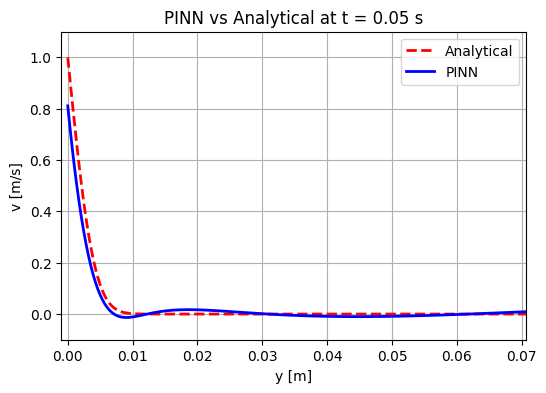

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.special import erf

# Parameters
nu = 1e-4
U0 = 1.0
T = 2.0
y_max = 5 * np.sqrt(nu * T)

y = np.linspace(0, y_max, 200).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(6,4))
line_analytical, = ax.plot([], [], 'r--', lw=2, label='Analytical')
line_pinn, = ax.plot([], [], 'b-', lw=2, label='PINN')
ax.set_xlim(-0.001, y_max)
ax.set_ylim(-0.1, U0 * 1.1)
ax.set_xlabel('y [m]')
ax.set_ylabel('v [m/s]')
ax.set_title('PINN vs Analytical Solution')
ax.legend()
ax.grid(True)

# Analytical solution
def analytical(y, t):
    return U0 * (1 - erf(y / (2 * np.sqrt(nu * t))))

# Update function
def update(frame):
    t_val = frame
    y_torch = torch.tensor(y, dtype=torch.float32)
    t_torch = torch.full_like(y_torch, t_val, dtype=torch.float32)

    # Make sure model is defined and on CPU
    with torch.no_grad():
        v_pinn = model(y_torch, t_torch).detach().cpu().numpy()

    v_analytical = analytical(y, t_val)

    line_analytical.set_data(y, v_analytical)
    line_pinn.set_data(y, v_pinn)

    ax.set_title(f'PINN vs Analytical at t = {t_val:.2f} s')
    return line_analytical, line_pinn

frames = np.linspace(0.05, T, 100)
ani = FuncAnimation(fig, update, frames=frames, blit=False, interval=100)

# Display in Colab
HTML(ani.to_jshtml())